In [2]:
import spinmob as s
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import scipy.optimize as opt
import os
import mcphysics as m
import seaborn as sns

# make plt plot inline
%matplotlib inline


  To disable warnings, set spinmob.settings['ignore_warnings']=True


1. conda install pip spyder pyqtgraph
2. pip install spinmob mcphysics imageio sounddevice

## Loading in the data

Calibration & Lead runs

In [3]:
user_path = '/Users/oliviapereira/Desktop' if (os.path.isdir('/Users/oliviapereira')) else '/Users/audrey/Documents/PHYS469'
folder_path = user_path + '/PHYS469/alpha_decay/raw_data/'  # path to data folder

am_data = m.data.load_chn(folder_path + 'am_source.chn')
pb_data = m.data.load_chn(folder_path + '11262024_longrun.Chn')
calibration_data = m.data.load_chn(folder_path + 'calibration_new/channel_counts.chn')

channels = calibration_data.columns['Channel']
am_counts = am_data.columns['Counts']
pb_counts = pb_data.columns['Counts']  
pulser_counts = calibration_data.columns['Counts'] 

In [13]:
pb_data.headers

{'description': 'EQ1032 preamp, 1500millitorr, Am sample, bi-amp',
 'start_time': {'year': 2024,
  'month': 11,
  'day': 19,
  'hour': 13,
  'minute': 3,
  'second': 2,
  'year_day': 324},
 'real_time': 595784.58,
 'live_time': 595782.78,
 'path': '/Users/oliviapereira/Desktop/PHYS469/alpha_decay/raw_data/11262024_longrun.Chn'}

Pressure runs

In [4]:
pressure_data_dict = {}
for p in [0, 100, 225]:
    pressure_data_dict[p] = m.data.load_chn(folder_path + f'{p}mbar.Chn')

In [5]:
pressure_data_dict[0].columns['Channel'], pressure_data_dict[0].columns['Counts']

(array([   0,    1,    2, ..., 2045, 2046, 2047]),
 array([0, 0, 0, ..., 0, 0, 0]))

## Adding in new calibration runs

In [6]:
folder_path = user_path + '/PHYS469/alpha_decay/raw_data/calibration_new'

# making an array of channel-voltage pairs, where the channel is the file name and the voltage is the peak y value in each file 
# txt files, headers are on row 29

# get all the files in the folder
files = os.listdir(folder_path)

# sort the files by channel number
files.sort()
files.remove('channel_counts.Chn')

# initialize the array
pulser_voltages = []
pulser_channels = []

# loop through the files
for file in files:
    # read the file
    data = np.genfromtxt(folder_path + '/' + file, skip_header=29)
    # get the peak y value
    peak = max(data[:,1])
    # # get the channel number
    channel = int(file.split('.')[0])
    # # add the pair to the array
    pulser_voltages.append(peak)
    pulser_channels.append(channel)

voltage_err = 0.0001

## Creating the energy scale

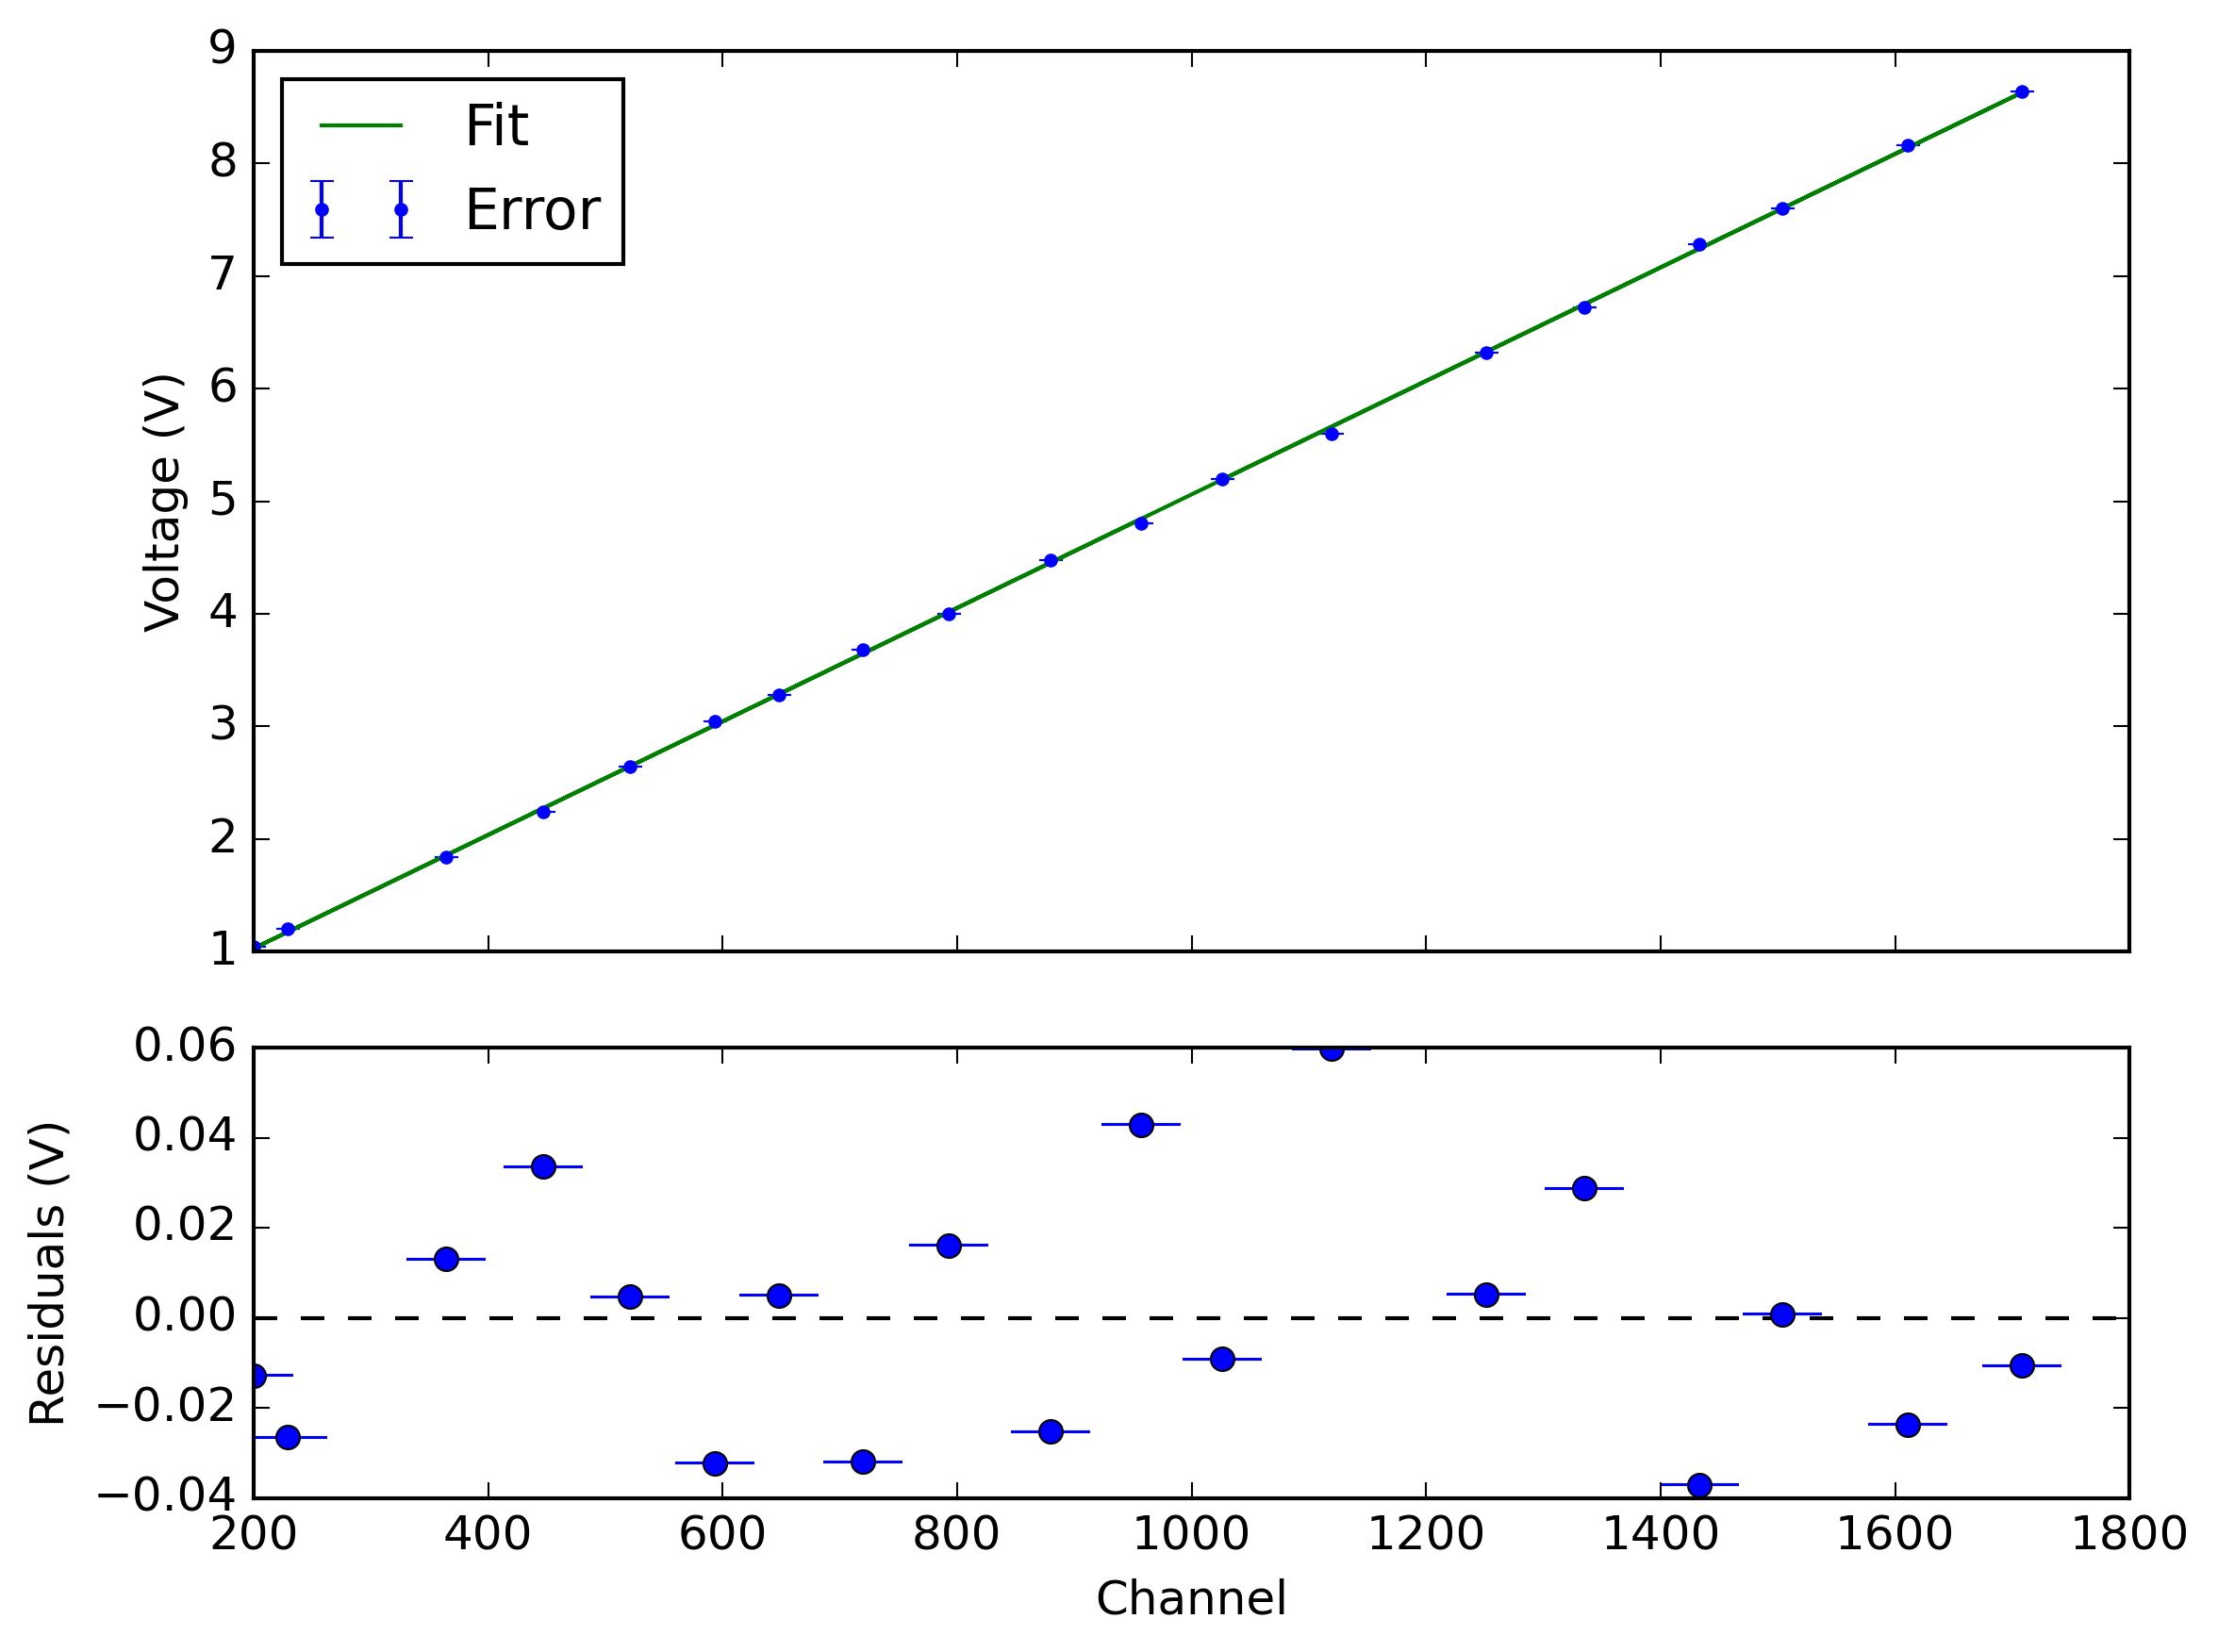

In [7]:
def line(channels, m, b):
    channels = np.array(channels)
    return m * channels + b

# using the Americium to get a known point: 
am_peak = np.where(am_counts == np.max(am_counts))[0][0]

# fit the calibration data
popt, pcov = opt.curve_fit(line, pulser_channels, pulser_voltages, p0=[1, 0])
m, b = popt
m_err = np.sqrt(pcov[0,0])
b_err = np.sqrt(pcov[1,1])

# plot the fit and residuals
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(8, 6), dpi = 300, gridspec_kw={'height_ratios': [2, 1]})

# Main plot
ax1.errorbar(pulser_channels, pulser_voltages, yerr=voltage_err, fmt='.', label='Error')
ax1.plot(pulser_channels, line(pulser_channels, m, b), label='Fit')
ax1.set_ylabel('Voltage (V)')
ax1.legend(loc = 'upper left')

# Residuals plot
ax2.errorbar(pulser_channels, line(pulser_channels, m, b) - pulser_voltages, yerr=voltage_err, fmt='o', capsize = 10)
ax2.axhline(0, color='black', linestyle='--')
ax2.set_xlabel('Channel')
ax2.set_ylabel('Residuals (V)')

plt.tight_layout()
plt.savefig(user_path + '/PHYS469/alpha_decay/figures/calibration.pdf', bbox_inches='tight')
plt.show()

### Fitting the americium energy

In [8]:
# Converting to energy scale
voltages = m * channels + b

# error propagation from fit onto voltages
voltage_err = np.sqrt(channel**2 * m_err**2 + b_err**2)

am_peak_energy = 5.486 # MeV
am_peak_channel = channels[am_peak]

am_peak_voltage = m * am_peak_channel + b
am_peak_voltage_err = 0.0001 # from measurements

energy = am_peak_energy * voltages / am_peak_voltage
energy_err = energy * np.sqrt((am_peak_voltage_err/am_peak_voltage)**2 + (voltage_err/voltages)**2)

# error on counts = sqrt(counts) for any counts (poisson statistics)

In [9]:
# chi square of our calibration fit
chi2 = np.sum((line(pulser_channels, m, b) - pulser_voltages)**2 / voltage_err**2)
dof = len(pulser_channels) - 2
reduced_chi2 = chi2 / dof

print(f'Chi^2: {chi2}')
print(f'Reduced Chi^2: {reduced_chi2}')

Chi^2: 34.41538035059767
Reduced Chi^2: 2.0244341382704514


## Energy and half-life analysis

The peaks are at channels: [484, 498, 522, 525, 752], corresponding to energies: [5.64819234 5.81038468 6.0884287  6.1231842  8.75301718] +- [0.04564528 0.04564532 0.04564538 0.04564539 0.04564614] MeV.


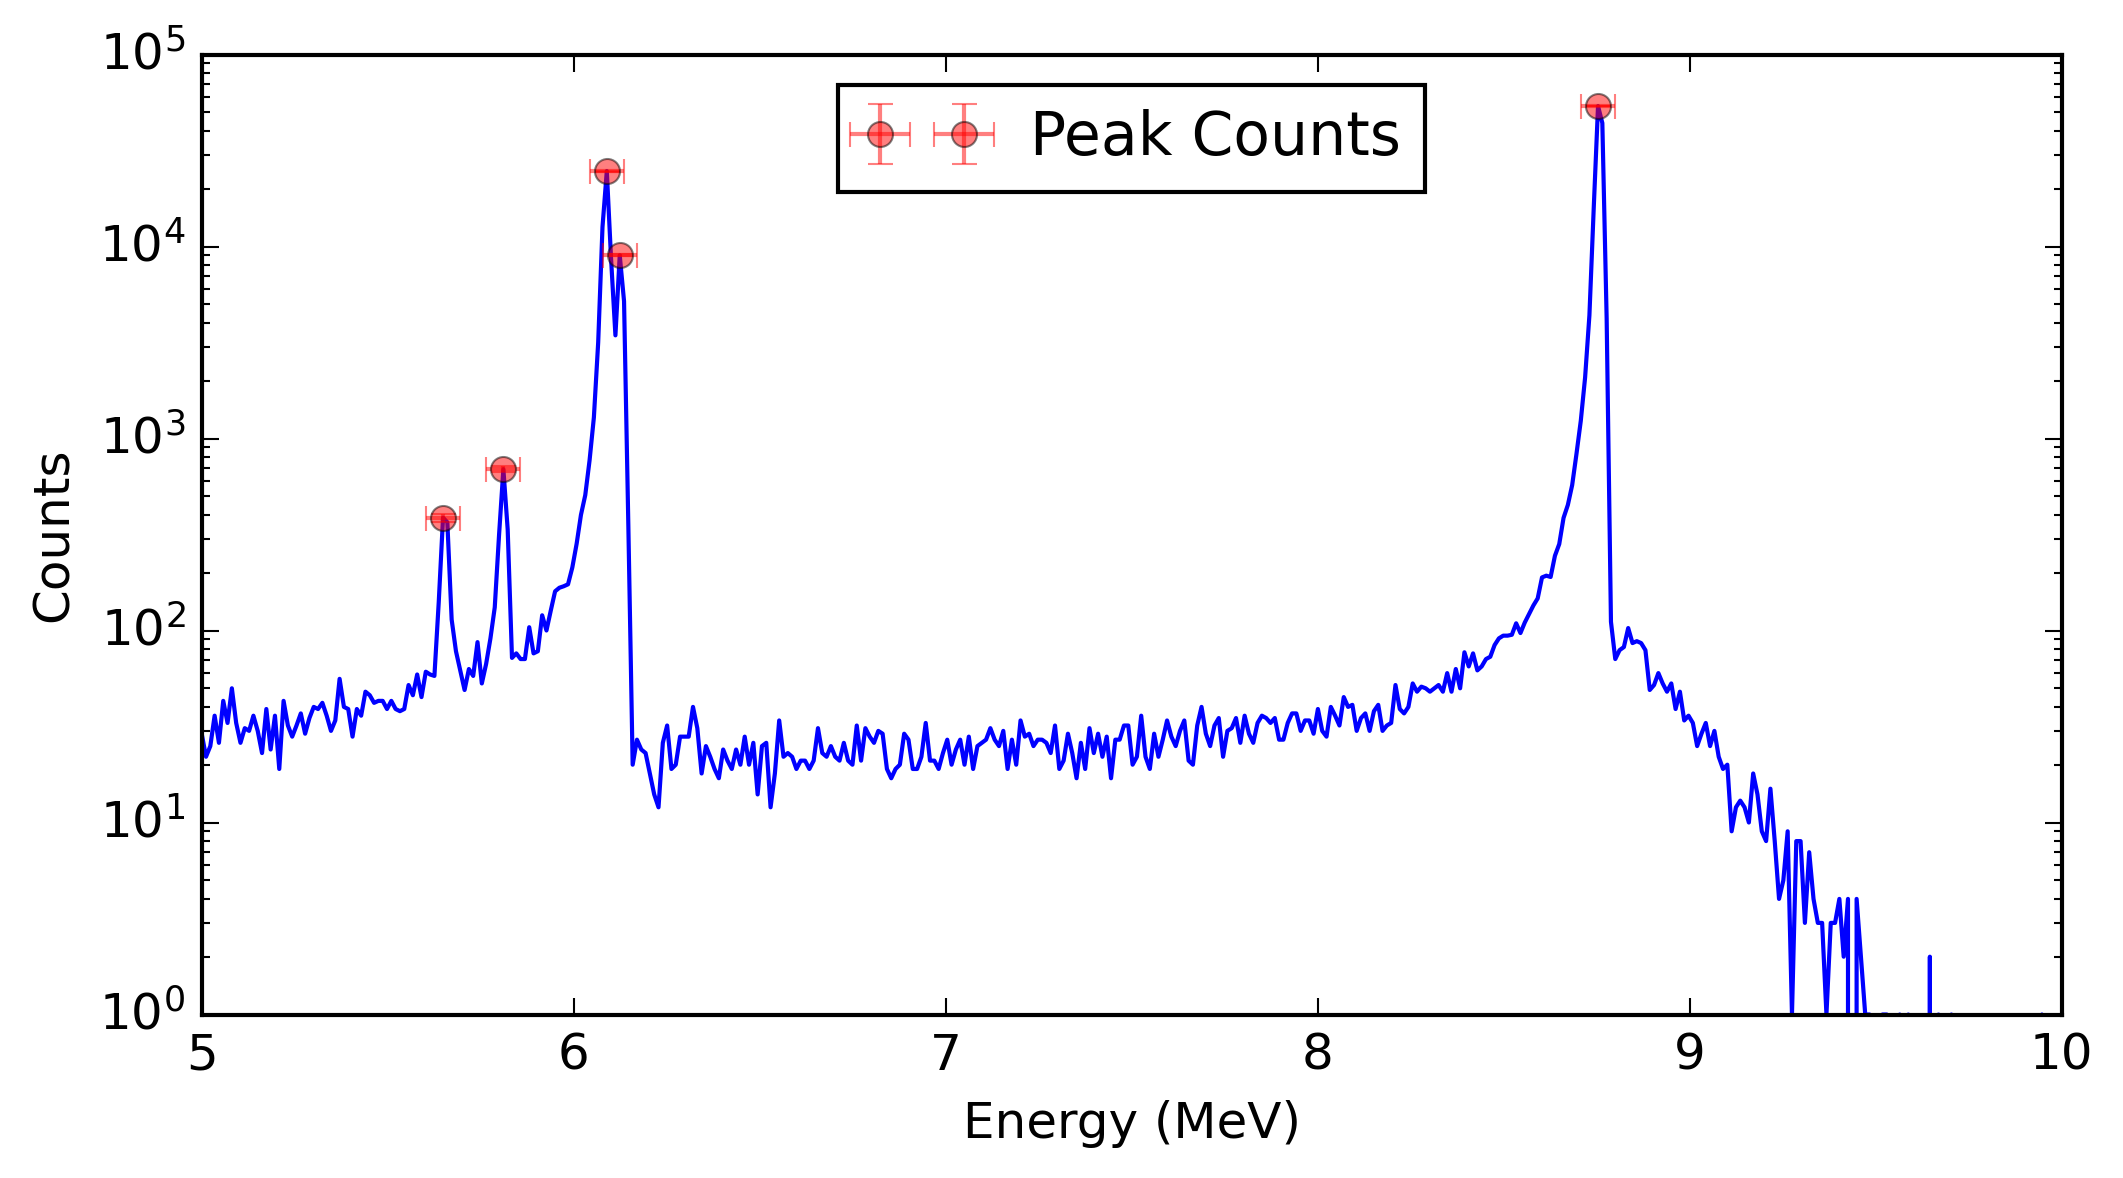

In [10]:
plt.figure(figsize=(8, 4), dpi = 300)
plt.plot(energy, pb_counts)
plt.xlim(5, 10)
plt.semilogy()
plt.xlabel('Energy (MeV)')
plt.ylabel('Counts')


# getting local maxima in spectra
peaks = []
for i in range(1, len(pb_counts) - 1000):
    if pb_counts[i] > 200:
        if pb_counts[i] > pb_counts[i - 1] and pb_counts[i] > pb_counts[i + 1]:
            peaks.append(i)

print(f'The peaks are at channels: {peaks}, corresponding to energies: {energy[peaks]} +- {energy_err[peaks]} MeV.')
plt.errorbar(energy[peaks], pb_counts[peaks], xerr = energy_err[peaks], yerr=np.sqrt(pb_counts[peaks]), fmt='o', color='red', label='Peak Counts', alpha = 0.5)
plt.legend(loc = 'upper center')

In [15]:
# calculate percent error for each
def percent_error(observed, expected):
    return abs(observed - expected) / expected * 100

expected_counts = [5.607, 5.768, 6.08988, 6.05078, 8.78486]
for i in range(len(peaks)):
    observed = energy[peaks[i]]
    expected = expected_counts[i]
    print(f'Percent error for peak {i + 1}: {percent_error(observed, expected)} %')

Percent error for peak 1: 0.7346592198542303 %
Percent error for peak 2: 0.7348246344392206 %
Percent error for peak 3: 0.02383133074190291 %
Percent error for peak 4: 1.1966094042509419 %
Percent error for peak 5: 0.3624738040072717 %


In [24]:
# getting the counts to calculate the relative abundance of each peak
peak_counts = [np.sum(pb_counts[peaks][:-1]), pb_counts[peaks][-1]]
peak_counts_err = np.sqrt(peak_counts)

# relative abundance of each peak
relative_abundance = peak_counts / np.sum(peak_counts) * 100
relative_abundance_err = relative_abundance * np.sqrt((peak_counts_err / peak_counts)**2)

# print results
for i in range(2):
    print(f'Relative abundance of peak {i + 1}: {relative_abundance[i]} +- {relative_abundance_err[i]}')

# percent error with respect to expected values
expected_abundances = []

Relative abundance of peak 1: 39.24897351441592 +- 0.2104116987475566
Relative abundance of peak 2: 60.75102648558408 +- 0.2617776359154954


## Making the multipanel

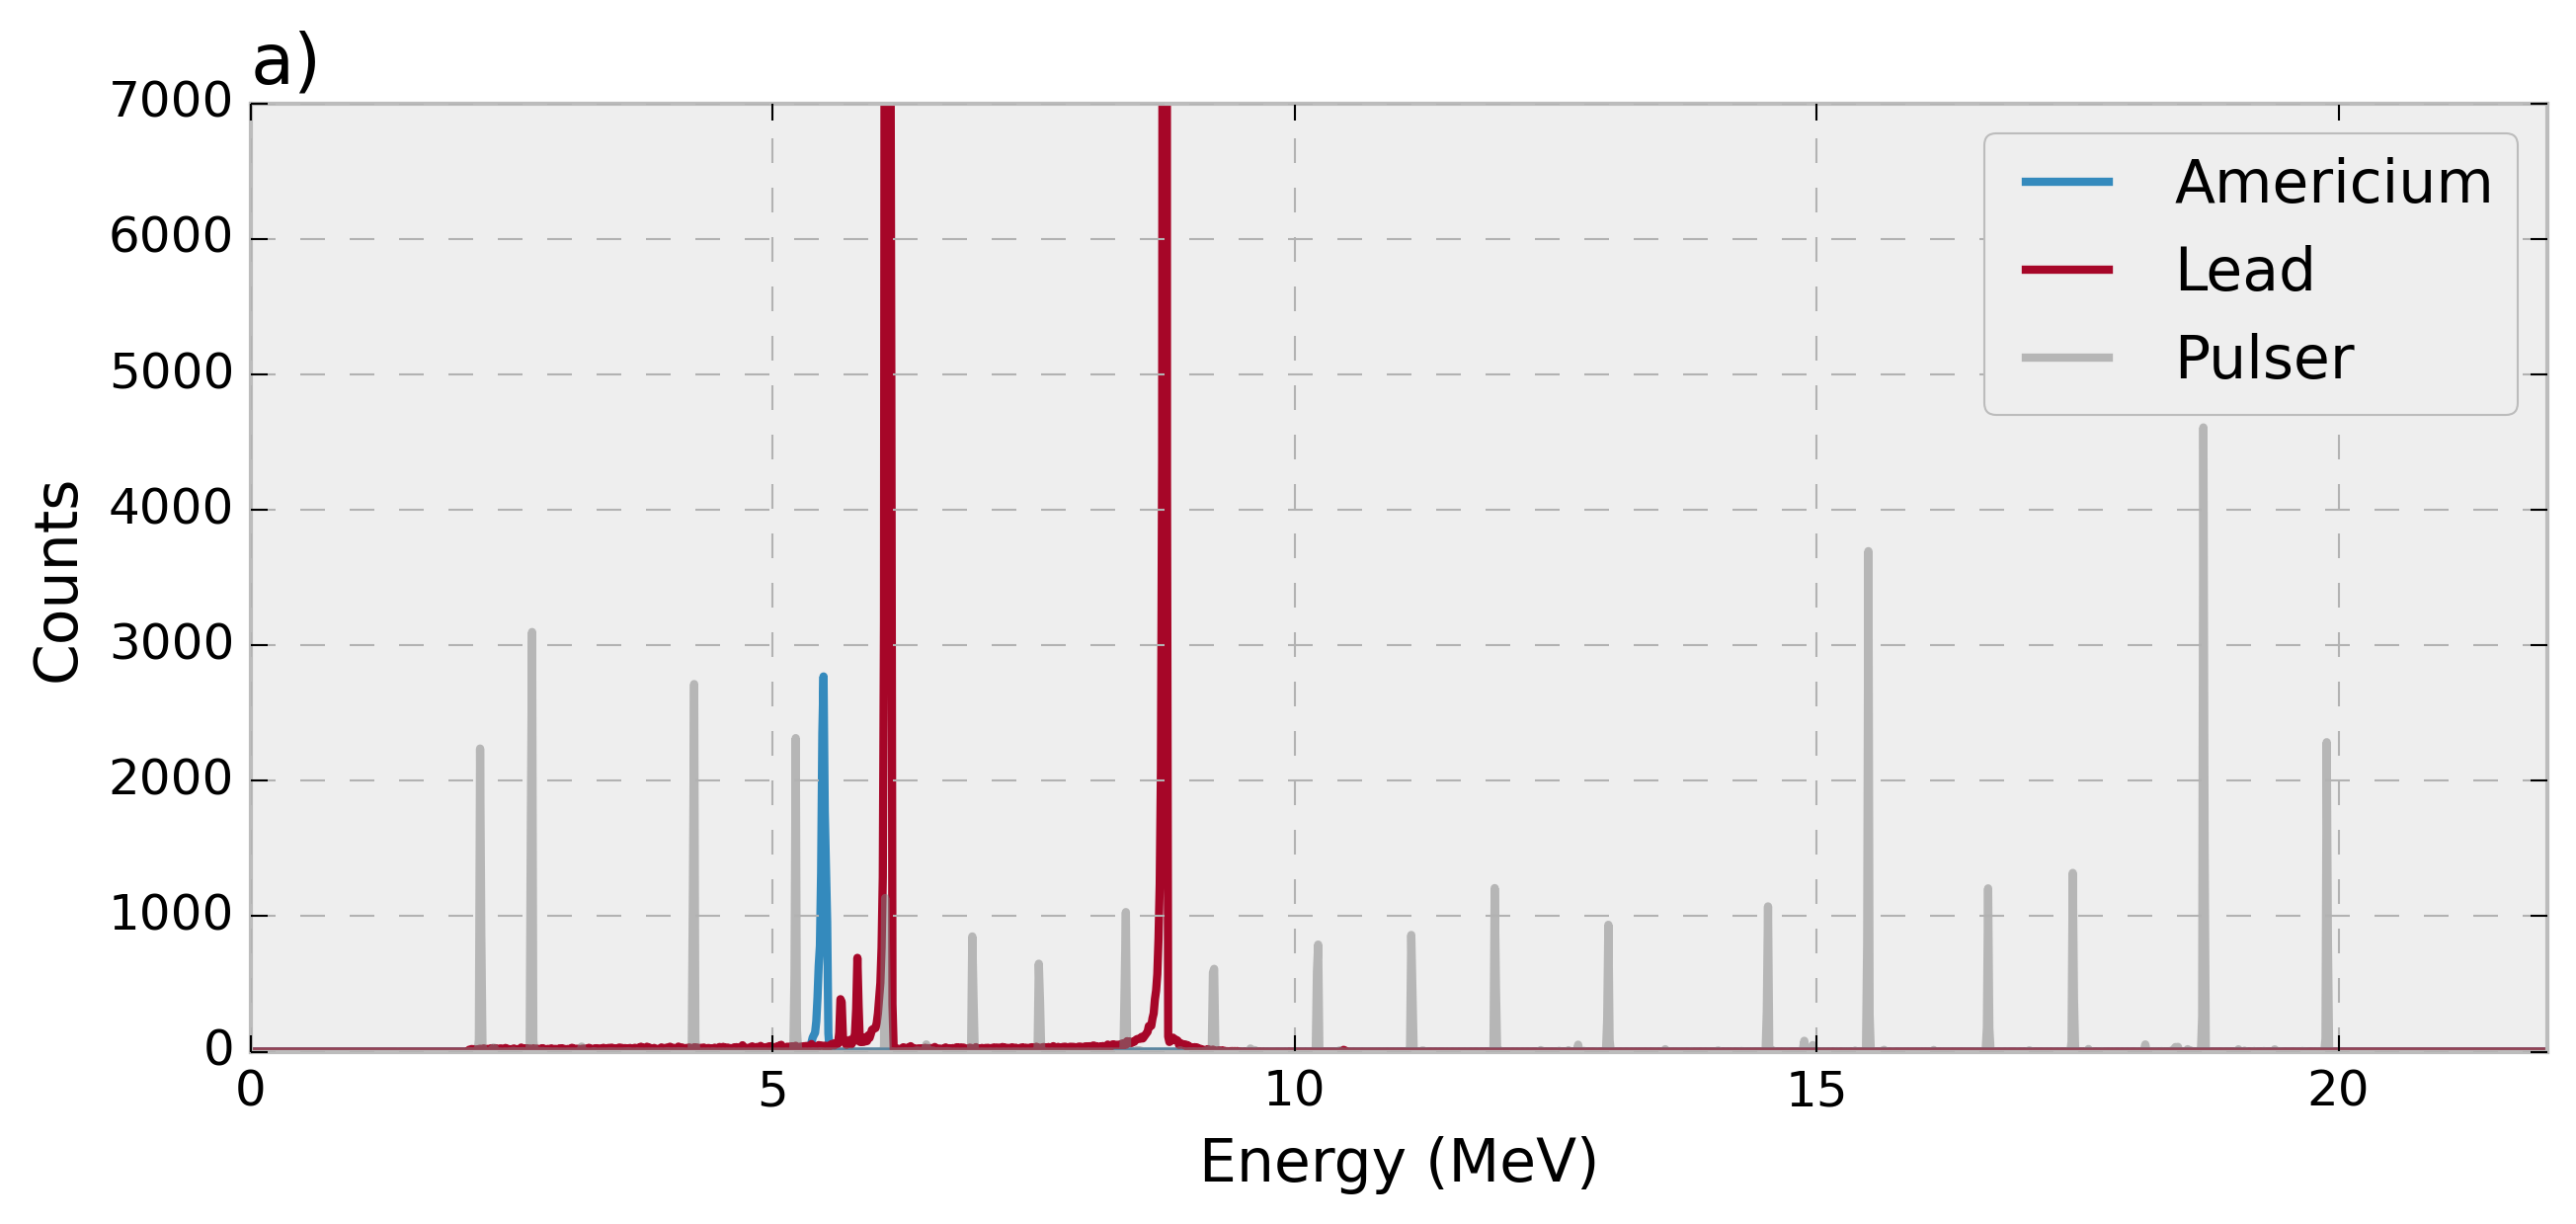

In [44]:
# plotting the spectra with our americium calibration data and the lead data 
plt.style.use('bmh')

plt.figure(figsize = (10, 4), dpi = 300)
plt.plot(energy, am_counts, label='Americium')
plt.plot(energy, pb_counts, label='Lead')
plt.plot(energy, pulser_counts, label='Pulser', color = 'grey', alpha = 0.5)
plt.xlabel('Energy (MeV)')
plt.ylabel('Counts')
plt.legend( loc = 'upper right', frameon = True)
plt.xlim(0, 22)
plt.ylim(0, 7000)
plt.title('a)', loc = 'left')
plt.savefig(user_path + '/PHYS469/alpha_decay/figures/spectra.pdf', bbox_inches='tight')
plt.show()

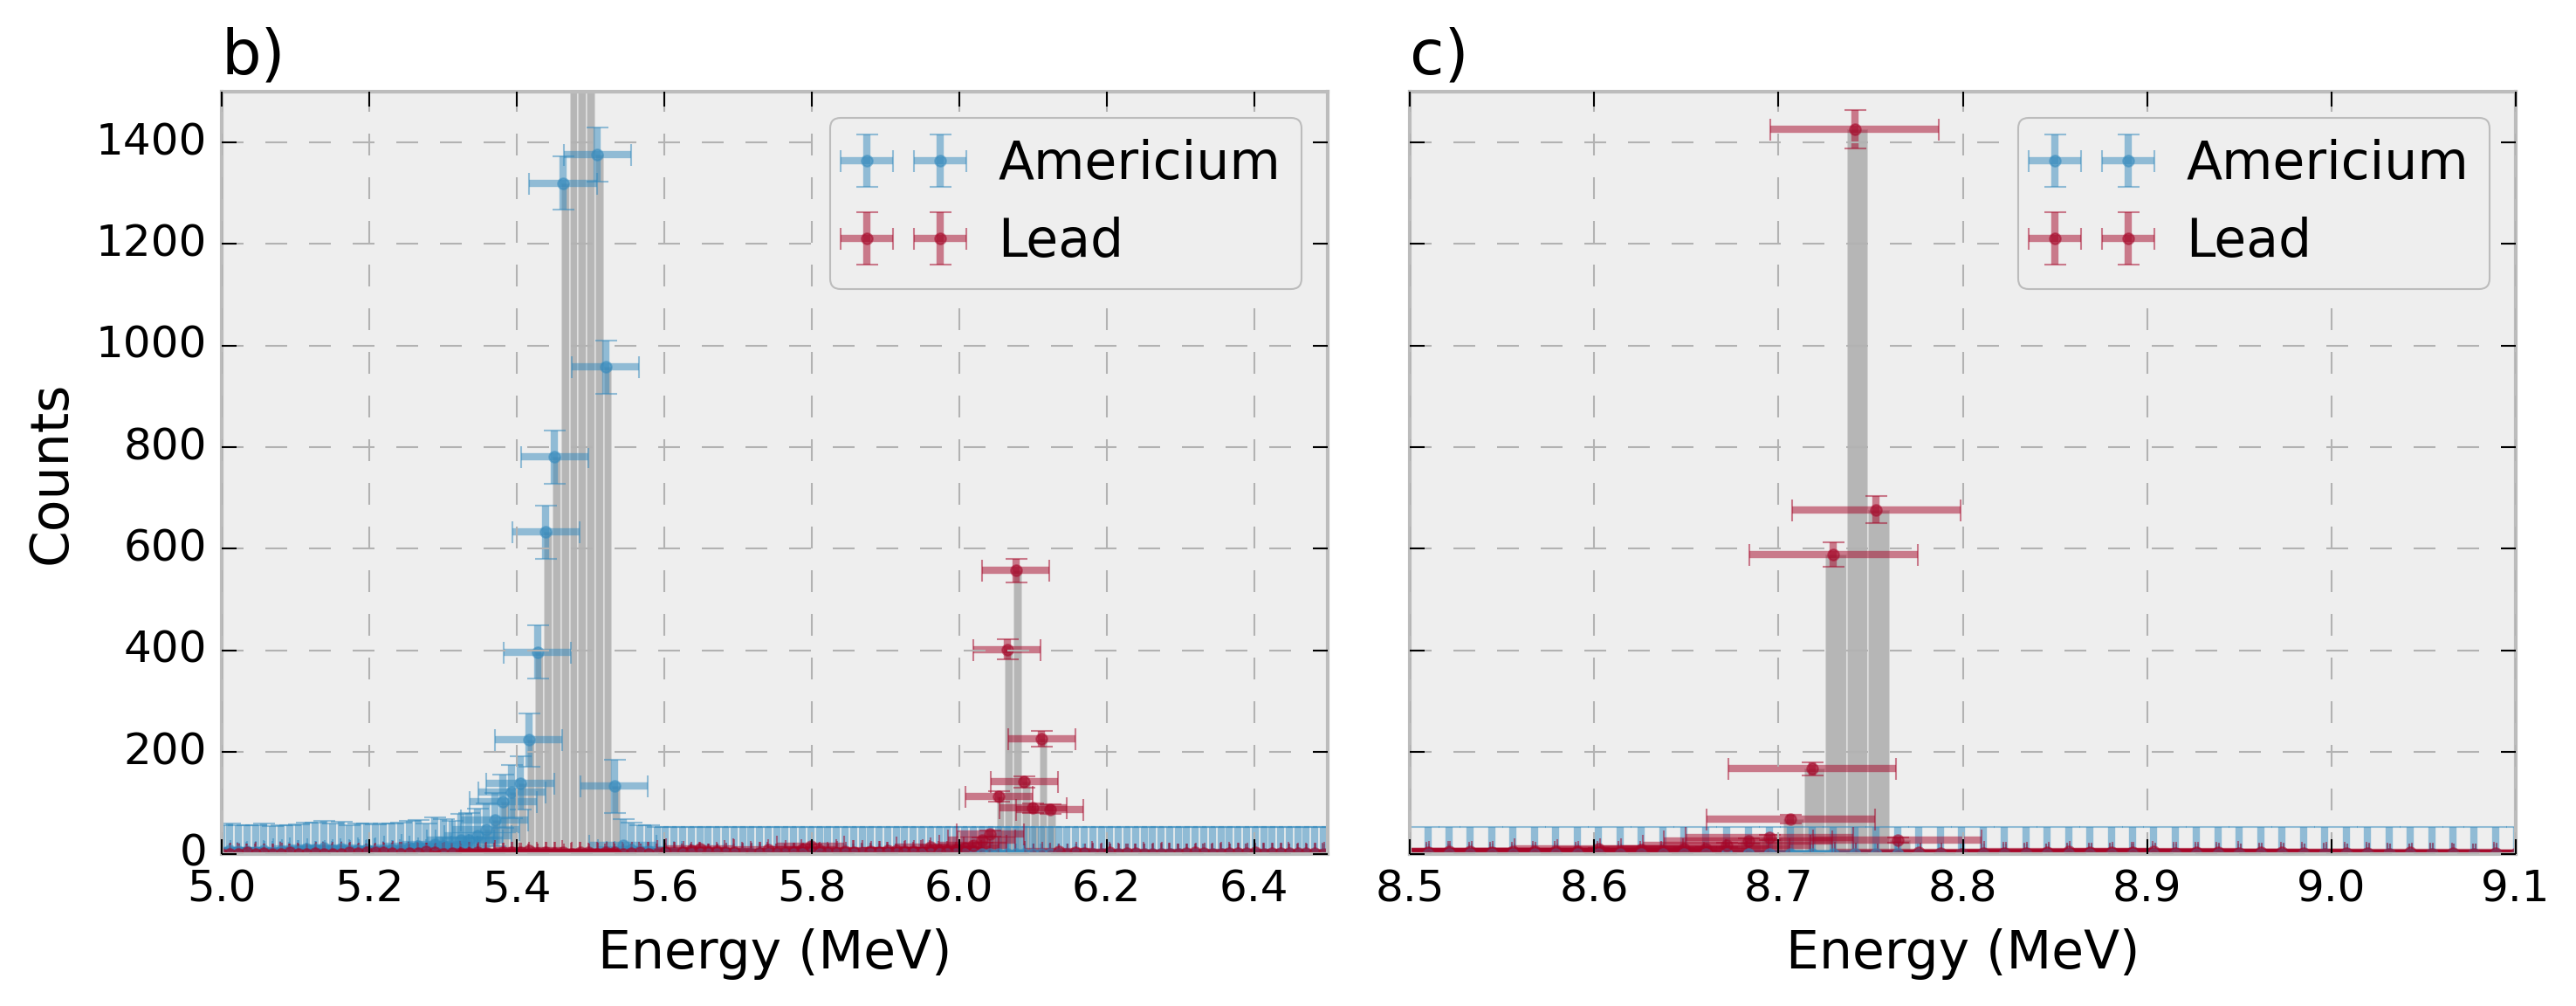

In [ ]:
# zooming in on the lead spectrum and plotting  with errors
from importlib import reload
reload(plt)

fig, ax = plt.subplots(1, 2, figsize=(10, 4), dpi=300, sharey=True)

# Left subplot
ax[0].hist(energy, bins=len(channels), weights=pb_counts, color='gray', alpha=0.5)
ax[0].hist(energy, bins=len(channels), weights=am_counts, color='gray', alpha=0.5)
ax[0].errorbar(energy, am_counts, xerr=energy_err, yerr=np.sqrt(am_counts), fmt='.', label='Americium', alpha=0.5)
ax[0].errorbar(energy, pb_counts, xerr=energy_err, yerr=np.sqrt(pb_counts), fmt='.', label='Lead', alpha=0.5)
ax[0].set_xlabel('Energy (MeV)')
ax[0].set_ylabel('Counts')
ax[0].legend(loc='upper right', frameon=True)
ax[0].set_title('b)', loc = 'left')
ax[0].set_xlim(5, 6.5)
ax[0].set_ylim(0, 1500)

# Right subplot
ax[1].hist(energy, bins=len(channels), weights=pb_counts, color='gray', alpha=0.5)
ax[1].hist(energy, bins=len(channels), weights=am_counts, color='gray', alpha=0.5)
ax[1].errorbar(energy, am_counts, xerr=energy_err, yerr=am_counts_err, fmt='.', label='Americium', alpha=0.5)
ax[1].errorbar(energy, pb_counts, xerr=energy_err, yerr=pb_counts_err, fmt='.', label='Lead', alpha=0.5)
ax[1].set_xlabel('Energy (MeV)')
ax[1].set_title('c)', loc = 'left')
ax[1].legend(loc='upper right', frameon=True)
ax[1].set_xlim(8.5, 9.1)

plt.tight_layout()
plt.savefig(user_path + '/PHYS469/alpha_decay/figures/zoom.pdf', bbox_inches='tight')
plt.show()

## Pressure Analysis